# Aufgabe für die Projektgruppe 3

Bearbeiten Sie die folgende Aufgabe:

Ihr Auftraggeber ist eine Familie, welche eine Beratung von Ihnen benötigt. Sie besitzt ein kleines altes Windrad, welches nur für den Eigenverbrauch genutzt wird sowie eine PV Anlage. Die Familie möchte von Ihnen wissen, ob Sie Kosten durch die Investition in verschiedene Komponenten ihres Energiesystems einsparen kann. 

Nehmen Sie dabei die folgenden Angaben an:
* Nennleistung der Windernergieanlage: 5 kW (Keine EEG- Vergütung)
* Nennleistung der PV-Anlage 9 kWp (70% Kappungsgrenze berücksichtigen)
* Die Anschlussleistung an das elektrische Netz beträgt 15 kW
* Die Heizleistung des Erdgaskessel liegt bei 20 kW, der Wirkungsgrad ist 99%
* Erdgaspreis: 7 cent/kWh
* Strompreis: 30 cent/kWh
* EEG-Vergütung PV Anlage: 12,30 cent/kWh

Prüfen und kombinieren Sie mindestens drei der unten aufgeführten Optionen und bewerten Sie diese nach ihrer wirtschaftlicher Vorteilhaftigkeit. Unter den gewählten Optionen sollte sich mindestens eine der beiden Optionen BHKW oder Wärmepumpe befinden:
- Implementierung eines Heizstabes mit annuitätische Kosten von 50€ (Elektrische Leistung 5 kW, Wirkungsgrad 98%) 
- Installation eines BHKWs mit annuitätische Kosten von 1.200€ (Elektrische Leistung 1kW, elektrischer Wirkungsgrad 16%, Thermischer Wirkungsgrad 80%, nehmen Sie eine feste Stromkennzahl von 0,2 an, ein Beispiel für die Implementierung eines BHKWs in PyPSA finden Sie hier: https://pypsa.org/examples/chp-fixed-heat-power-ratio.html. Eine KWK-Vergütung müssen Sie nicht implementieren, da hier die pauschalierte Zuschlagzahlung gewählt wird.)
- Beschaffung einer elektrischen Batterie mit annuitätische Kosten von 900€ (8kWh Kapazität, 2,4 kW Speicher und Ladeleistung, einem Gesamtwirkungsgrad von 85%, keine Selbstentladungsverluste) 
- Erweiterung des Heizungssystems um einen thermischen Speicher mit annuitätische Kosten von 100€ (7kWh Kapazität und eine Ein und Ausspeicherleistung von 12 kW, keine Selbstentladungsverluste)
- Implementierung einer selbst gewählten Wärmepumpe. Hier müssen Sie nach geeigneten Daten zu Leistungen, Kosten und Performance recherchieren. Sie dürfen dabei die Jahresarbeitszahl als konstanten COP annehmen. Gehen Sie weiter davon aus, dass der Annuitätenfaktor für eine solche Investition bei 0,117 liegt.

1) Formulieren Sie die Optimierungsaufgabe
2) Skizzieren Sie das heutige System und bestimmen Sie die Kosten.
3) Skizzieren Sie mögliche Erweiterungen und bestimmen Sie die Kosten.
4) Interpretieren Sie die ihre Ergebnisse und ziehen Sie Schlussfolgerungen.
5) Bestimmen Sie die Grenzen Ihrer Modellierung und begründen Sie, ob die Ergebnisse trotz der Beschränkungen valide sind.

Der Import der Lastzeitreihen und der Einspeisezeitreihen ist unten schon vorbereitet. Diese repräsentieren das Jahr 2018 in stündlicher Auflösung. Nutzen Sie das in der Übung besprochene JupyterNotebook und schauen Sie sich die Funktionen und den Code dort an, um Ihr Energiesystem aufzubauen, es zu simulieren und auszuwerten.  

# Import <a class="anchor" id="chapter1"></a>

## Import der benötigten Python Module <a class="anchor" id="section_1_1"></a>

In [1]:
import pypsa
import pandas as pd
import math
import numpy as np

## Import der Daten <a class="anchor" id="section_1_2"></a>

Die Werte der Zeitreihen sind in einem Unterordner "data" als csv-Datein abgelegt. Sie bilden das Jahr 2019 ab und werden mithilfe des Python Moduls pandas eingelesen und als Variablen angelegt. Dabei werden Parameter wie der Separator (hier ";") und die Indexspalte sowie die Funktion, aus der Indexspalte Zeit und Datenformate auszulesen gesetzt.

In [2]:
pv_infeed = pd.read_csv('./data/pv_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)
wind_infeed = pd.read_csv('./data/wind_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)

In [3]:
electrical_load = pd.read_csv('./data/SumProfiles_3600s.Electricity.csv', sep = ';', index_col='time', parse_dates=True)
thermal_load = pd.read_csv('./data/SumProfiles_3600s.Gas.csv', sep = ';', index_col='time', parse_dates=True)


Die eingelesenen Zeitreihen sind so noch nicht vollständig nutzbar. Um die Einspeisung der Wind und PV-Anlage zu normieren wird eine neue Spalte mit dem normierten Leistungsoutput sowie neue Spalten mit der Leistung der Last in den jeweiligen Variablen angelegt.

In [4]:
#Die gemessene PV-Einspeiseganglinie ist von einer Anlage mit einer Leistung von 9 kWp, die der Windenergieanlage mit 5 kW.
pv_infeed['p_max_pu'] = pv_infeed.electricity/9 
wind_infeed['p_max_pu'] = wind_infeed.electricity/5 

Um einen kurzen Einblick in die Daten zu erhalten, schauen wir uns alle vier Tabellen an:

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

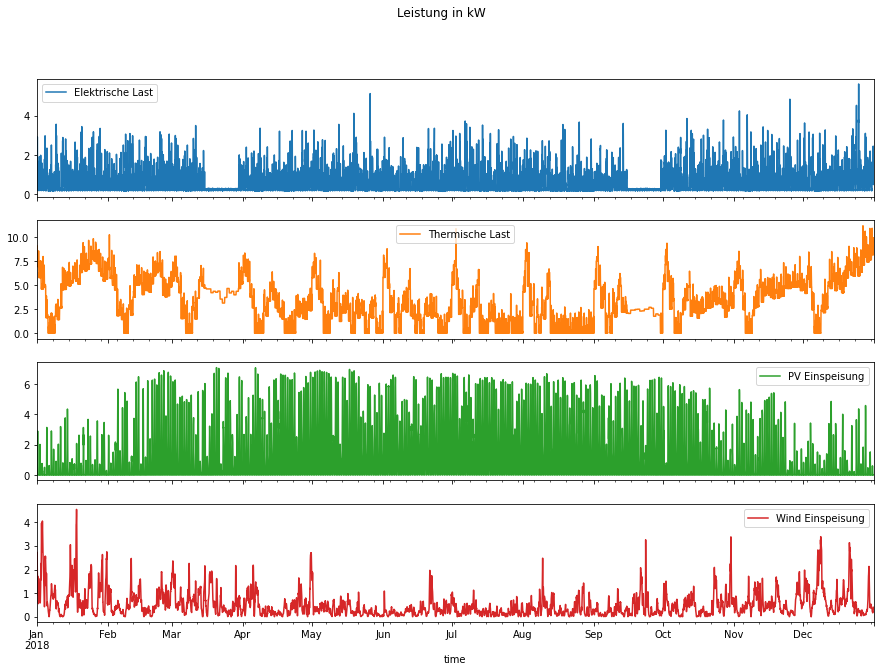

In [5]:
df_figure = pd.concat([electrical_load.sum_kwh, thermal_load.sum_kwh, pv_infeed.electricity,wind_infeed.electricity], axis = 1)
df_figure.columns = ['Elektrische Last', 'Thermische Last', 'PV Einspeisung', 'Wind Einspeisung']
df_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = True, figsize=(15,10), title= 'Leistung in kW')

In [6]:
# Ab hier können Sie selbst Code schreiben und das Energiesystem simulieren.

# Definition der Variablen und Objekte <a class="anchor" id="chapter2"></a>

## Definition von Anlagenparametern <a class="anchor" id="section_2_1"></a>

### Komponenten des Haushalts <a class="anchor" id="section_2_1_1"></a>

In [7]:
# PV-Anlage
pv = {"electrical_power": 9.0} #Leistung der PVA wird auf 9 kW festgelegt

# Wind-Anlage
wind = {"electrical_power": 5.0} #Leistung der WEA wird auf 5 kW festgelegt

#Heizkessel
heating_boiler = {"thermal_power": 20.0, #Leistung des Erdgaskessel wird auf 20 kW festgelegt
                   "efficiency":0.99,# Effizienz des Erdgaskessel wird auf 99% festgelegt
                   "gas_costs": 7} #Erdgaspreis wird auf 7 cent/kWh festgelegt                   

### Netzanschluss <a class="anchor" id="section_2_1_2"></a>

Der Netzanschluss wird für den Haushalt mit 15 kW angenommen. Hier ist auch eine Kappungsgrenze bei 70% der Nennleistung der PV-Anlage implementiert.

In [8]:
#Leistungsbezug aus dem Netz
grid_import = {"electrical_power" : 15, #maximale Bezugsleistung aus dem Netz
                "electricity_price": 30.0} #Preis für den Netzbezug in cent/kWh

#PV Leistungsabgabe in das Netz
grid_export_pv = {"electrical_power_pv" : 0.7 * pv["electrical_power"], #Repräsentiert die 70% Kappungsgrenze bei kleinen PV-Anlagen
                "electricity_revenue": 12.3} #EEG-Erlöse in cent/kWh für Einspeisung

## Verwendung von PyPSA um das Energiemodell aufzubauen <a class="anchor" id="section_2_2"></a>

### Definition des Netzwerks  <a class="anchor" id="section_2_2_1"></a>

In [9]:
#Netzwerk definieren
network = pypsa.Network() # Die Variable für das Netzwerk wird eingefüht und als PyPSA Objekt, definiert
network.set_snapshots(pv_infeed.index) #Erstellen der Zeitabschnitten für die ges. Simulation aus den PV-Daten


#Knoten erstellen
network.add("Bus", #der Knoten für die Elektische Seite wird erstellt
            name = "electricity") #der Knoten für die Elektische Seite wird benannt

network.add("Bus", #der Knoten für die PV Seite wird erstellt
            name = "pv_node")

network.add("Bus", #der Knoten für die thermisch Seite wird erstellt
            name = "thermal")


#Lasten definieren
network.add("Load", #Die elektrische Last wird erstellt
            name ="electricity_load", #Name wird gesetzt
            bus = "electricity", #angeschlossen am Knoten für Elektrik
            p_set = electrical_load.sum_kwh) #auslesung der Leustung aus der Datei.Spalte Umrechnung in kW nicht notwendig, da Zeitintervall in der Quelle 1h

network.add("Load", # Thermische last
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)


#Erzeugungseinheiten definieren
network.add("Generator", #PV-Anlage
            name = "pv",
            bus = "pv_node", #Leistung wird von oben aus der Variable abgerufen (hätte man auch hier eintippen können, wird aber auch später öffter benötigt)
            p_nom = pv["electrical_power"], #Verfügbare Leistung je Zeitpunkt wird aus der Datei gelesen
            p_max_pu = pv_infeed.p_max_pu, #keine Erzeugungkosten
            marginal_cost = 0) #keine Erzeugungkosten

network.add("Generator", #Wind-Anlage
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

network.add("Generator", #Heizkessel
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], #werte werden von oben ausgelsen
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"]) #kosten werden mit den Angaben oben errechneet


#Netzanschluss definieren
network.add("Generator", #Netzbezug
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

network.add("Generator", #Netzeinspeisung pv
            name = "grid_export_pv",
            bus = "pv_node", 
            p_nom = grid_export_pv["electrical_power_pv"], 
            marginal_cost = -grid_export_pv["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.


#Verbindung der Knoten
network.add("Link", 
            name = "pv_node_to_electricity", 
            bus0 = "pv_node", 
            bus1 = "electricity", 
            p_nom = pv["electrical_power"])

#### Skizze des Basis-Systems
<img src="data/Base.png">

# Simulation <a class="anchor" id="chapter3"></a>

## Simulation der Basiskonfiguration <a class="anchor" id="section_3_1"></a>

In [10]:
# Simulation der Basiskonfiguration für den kompletten Zeitraum:
network.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.73s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.14e+05


('ok', 'optimal')

In [11]:
#Auswertung der Kosten und Anteile
def cost_share_evaluation(network):
    '''
    This function evaluate the solved PyPSA network to get the costs, revenues and the share of the selfconsumption.
    
    Parameters
    ----------
    network:            PyPSA Network
                        The solved PyPSA network with all corresponding devices
    Returns
    -------
    results :           dict
                        The dictionary with all the results.
    '''
    
    production_pv =(network.generators_t.p['pv']).sum()
    production_wind =(network.generators_t.p['wind']).sum()
    
    grid_import = (network.generators_t.p['grid_import']).sum() #was wurde aus dem Netz bezogen (Jeweilige realleitung "p" des generators "grid_import" * jeweilige zeit [kw*h] und davon die Summe)  
    
    grid_export_pv = (network.generators_t.p['grid_export_pv']).sum()
    
    self_consumed_pv = (network.generators_t.p['pv']).sum()- grid_export_pv
    self_consumed_wind = (network.generators_t.p['wind']).sum()
    self_consumed_all = self_consumed_pv + self_consumed_wind
    
    consumed_total = self_consumed_all + grid_import
    
    self_consumption_ratio_pv = self_consumed_pv/(network.generators_t.p['pv']).sum()
    self_consumption_ratio_wind = self_consumed_wind/(network.generators_t.p['wind']).sum()
    self_consumption_ratio_all = self_consumed_all/((network.generators_t.p['pv']).sum() + (network.generators_t.p['wind']).sum())
    
    electricity_cost = grid_import * network.generators.marginal_cost['grid_import']
    electricty_revenues = grid_export_pv * network.generators.marginal_cost['grid_export_pv']
    gas_costs = (network.generators_t.p['boiler']).sum() * network.generators.marginal_cost['boiler']
    
    curtailment = ((network.generators_t.p_max_pu['pv']*network.generators.p_nom['pv'] - network.generators_t.p['pv'])).sum()
    

    results = {"Erzeugung_PV":production_pv,
              "Erzeugung_wind":production_wind,
              "Netzbezug":grid_import,
              "Netzeinspeisung_PV":grid_export_pv,
              "Eigenverbrauch_PV":self_consumed_pv,
              "Eigenverbrauch_wind":self_consumed_wind,
              "Eigenverbrauch_all":self_consumed_all,
              "Verbrauch_total":consumed_total,
              "Eigenverbrauchsanteil_pv": self_consumption_ratio_pv,
              "Eigenverbrauchsanteil_wind": self_consumption_ratio_wind,
              "Eigenverbrauchsanteil_all": self_consumption_ratio_all,
              "Stromkosten": electricity_cost,
              "Gaskosten": gas_costs,
              "Stromerlöse": -electricty_revenues,
              "Gesamtkosten": (electricity_cost + gas_costs) + electricty_revenues,
              "Abregelung_PV": curtailment
            }
    results_energy = {'Abregelung': curtailment,
                      'Netzeinspeisung_pv': grid_export_pv,
                      'Eigenverbrauch_pv': self_consumed_pv,
                      'Eigenverbrauch_wind': self_consumed_wind,
                      'Eigenverbrauch_all': self_consumed_all,
                      'Netzbezug': -grid_import}
                      
    return results, results_energy

In [12]:
results_base, results_energy_base  = cost_share_evaluation(network)

#Die Werte sollen auch als Text ausgegeben werden
print("Erzeugung_PV "+str(round(results_base["Erzeugung_PV"],2)))
print("Abregelung_PV "+str(round(results_base["Abregelung_PV"],2)))
print("Erzeugung_wind "+str(round(results_base["Erzeugung_wind"],2)))
print("Netzbezug "+str(round(results_base["Netzbezug"],2)))
print("Netzeinspeisung_PV "+str(round(results_base["Netzeinspeisung_PV"],2)))
print("Eigenverbrauch_PV "+str(round(results_base["Eigenverbrauch_PV"],2)))
print("Eigenverbrauch_wind "+str(round(results_base["Eigenverbrauch_wind"],2)))
print("Eigenverbrauch_all "+str(round(results_base["Eigenverbrauch_all"],2)))
print("Verbrauch_total "+str(round(results_base["Verbrauch_total"],2)))
print("Eigenverbrauchsanteil_pv "+str(round(results_base["Eigenverbrauchsanteil_pv"]*100,2))+"%")
print("Eigenverbrauchsanteil_wind "+str(round(results_base["Eigenverbrauchsanteil_wind"]*100,2))+"%")
print("Eigenverbrauchsanteil_all "+str(round(results_base["Eigenverbrauchsanteil_all"]*100,2))+"%")
print("Stromkosten "+str(round(results_base["Stromkosten"]/100,2)))
print("Gaskosten "+str(round(results_base["Gaskosten"]/100,2)))
print("Stromerlöse "+str(round(results_base["Stromerlöse"]/100,2)))
print("Gesamtkosten "+str(round(results_base["Gesamtkosten"]/100,2)))

Erzeugung_PV 11066.2
Abregelung_PV 27.3
Erzeugung_wind 2398.88
Netzbezug 1571.97
Netzeinspeisung_PV 9969.51
Eigenverbrauch_PV 1096.7
Eigenverbrauch_wind 2398.88
Eigenverbrauch_all 3495.57
Verbrauch_total 5067.54
Eigenverbrauchsanteil_pv 9.91%
Eigenverbrauchsanteil_wind 100.0%
Eigenverbrauchsanteil_all 25.96%
Stromkosten 471.59
Gaskosten 1891.83
Stromerlöse 1226.25
Gesamtkosten 1137.17


In [13]:
#results_base, results_energy_base  = cost_share_evaluation(network)

#Die Werte sollen auch als Text ausgegeben werden
#print("Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt "
#      + str(round(results_base["Eigenverbrauchsanteil_all"]*100,2))
#      +"%. Dabei entstehen Stromkosten von "
#      +str(round(results_base["Stromkosten"]/100,2))
#      +"€, Gaskosten von "
#      +str(round(results_base["Gaskosten"]/100,2))
#      +"€ und EEG-Erlöse von "
#      +str(round(results_base["Stromerlöse"]/100,2))
#      +", wobei " +str(round(results_base["Nicht nutzbare Energie"]/100,1))+ "kWh PV-Strom abgeregelt werden muss."
#      +" Die Gesamtkosten betragen "+ str(round(results_base["Gesamtkosten"]/100,2)) +"€."
#     )

<AxesSubplot:xlabel='time'>

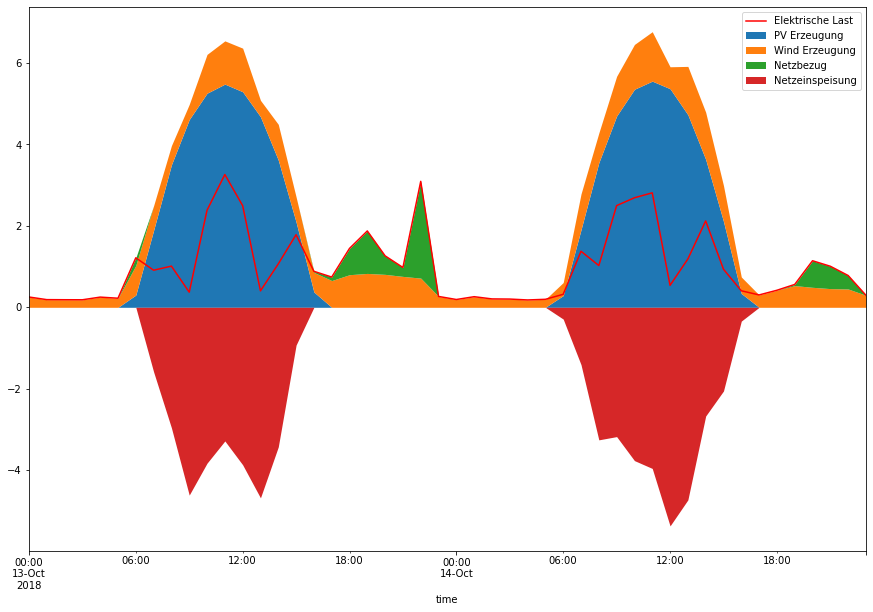

In [14]:
load_figure = network.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['10-13-18 00:00:00':'10-14-18 23:50:00'].plot(legend = True, color = 'red')
df_figure_base = pd.concat([network.generators_t.p['pv'],network.generators_t.p['wind'], network.generators_t.p['grid_import'], -network.generators_t.p['grid_export_pv']], axis = 1)
df_figure_base.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc['10-13-18 00:00:00':'10-14-18 23:50:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)


## Erweiterung der Konfiguration

### Nutzung der Batterie

#### Skizze des Systems mit Batterie
<img src="data/Bat.png">

Erneuter aufbau des Netzwerkes unter anderem Namen

In [15]:
#Netzwerk definieren
network_modified_bat = pypsa.Network() # Die Variable für das Netzwerk wird eingefüht und als PyPSA Objekt, definiert
network_modified_bat.set_snapshots(pv_infeed.index) #Erstellen der Zeitabschnitten für die ges. Simulation aus den PV-Daten


#Knoten erstellen
network_modified_bat.add("Bus", #der Knoten für die Elektische Seite wird erstellt
            name = "electricity") #der Knoten für die Elektische Seite wird benannt

network_modified_bat.add("Bus", #der Knoten für die PV Seite wird erstellt
            name = "pv_node")

network_modified_bat.add("Bus", #der Knoten für die thermisch Seite wird erstellt
            name = "thermal")


#Lasten definieren
network_modified_bat.add("Load", #Die elektrische Last wird erstellt
            name ="electricity_load", #Name wird gesetzt
            bus = "electricity", #angeschlossen am Knoten für Elektrik
            p_set = electrical_load.sum_kwh) #auslesung der Leustung aus der Datei.Spalte Umrechnung in kW nicht notwendig, da Zeitintervall in der Quelle 1h

network_modified_bat.add("Load", # Thermische last
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)


#Erzeugungseinheiten definieren
network_modified_bat.add("Generator", #PV-Anlage
            name = "pv",
            bus = "pv_node", #Leistung wird von oben aus der Variable abgerufen (hätte man auch hier eintippen können, wird aber auch später öffter benötigt)
            p_nom = pv["electrical_power"], #Verfügbare Leistung je Zeitpunkt wird aus der Datei gelesen
            p_max_pu = pv_infeed.p_max_pu, #keine Erzeugungkosten
            marginal_cost = 0) #keine Erzeugungkosten

network_modified_bat.add("Generator", #Wind-Anlage
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

network_modified_bat.add("Generator", #Heizkessel
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], #werte werden von oben ausgelsen
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"]) #kosten werden mit den Angaben oben errechneet


#Netzanschluss definieren
network_modified_bat.add("Generator", #Netzbezug
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

network_modified_bat.add("Generator", #Netzeinspeisung pv
            name = "grid_export_pv",
            bus = "pv_node", 
            p_nom = grid_export_pv["electrical_power_pv"], 
            marginal_cost = -grid_export_pv["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.


#Verbindung der Knoten
network_modified_bat.add("Link", 
            name = "pv_node_to_electricity", 
            bus0 = "pv_node", 
            bus1 = "electricity", 
            p_nom = pv["electrical_power"])

#### Erweiterung um die Batterie

annuitätische Kosten von 900€ (8kWh Kapazität, 2,4 kW Speicher und Ladeleistung, einem Gesamtwirkungsgrad von 85%, keine Selbstentladungsverluste)

In [16]:
# Hilfsknoten
network_modified_bat.add("Bus", 
            name = "storage_electricity")

#Einspeicherleistung vom Knoten "electricity" zum Knoten "storage_electricity"
network_modified_bat.add("Link", 
            name = "electrical_storage_charge", 
            bus0 = "electricity", 
            bus1 = "storage_electricity", 
            p_nom = 2.4,
            efficiency = math.sqrt(0.85)) #Wurzel von 85% da sqrt_ein(0,85) * sqrt_aus(0,85) = 85% gesamt

#Ausspeicherleistung vom Knoten "storage_electricity" zum Knoten "electricity"
network_modified_bat.add("Link", 
            name = "electricity_storage_discharge", 
            bus0 = "storage_electricity", 
            bus1 = "electricity", 
            p_nom = 2.4, 
            efficiency = math.sqrt(0.85)) #Wurzel von 85% da sqrt_ein(0,85) * sqrt_aus(0,85) = 85% gesamt

#Speicher
network_modified_bat.add("Store", 
            name = "electricity_storage", 
            bus = "storage_electricity", 
            e_nom = 8, #Nominal energy capacity (in Dokumentation ist die Einheit in [MWh] angegeben. Waum hier [kWh]?)
            e_cyclic = True,)# Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen

annu_cost_bat = 900
                        

In [17]:
# Simulation für den kompletten Zeitraum:
network_modified_bat.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 2.65s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.20e+04


('ok', 'optimal')

In [18]:
results_with_modified_bat, results_energy_with_modified_bat  = cost_share_evaluation(network_modified_bat)

#Die Werte sollen auch als Text ausgegeben werden
print("Erzeugung_PV "+str(round(results_with_modified_bat["Erzeugung_PV"],2))+" vorher "+str(round(results_base["Erzeugung_PV"],2)))
print("Abregelung_PV "+str(round(results_with_modified_bat["Abregelung_PV"],2))+" vorher "+str(round(results_base["Abregelung_PV"],2)))
print("Erzeugung_wind "+str(round(results_with_modified_bat["Erzeugung_wind"],2))+" vorher "+str(round(results_base["Erzeugung_wind"],2)))
print("Netzbezug "+str(round(results_with_modified_bat["Netzbezug"],2))+" vorher "+str(round(results_base["Netzbezug"],2)))
print("Netzeinspeisung_PV "+str(round(results_with_modified_bat["Netzeinspeisung_PV"],2))+" vorher "+str(round(results_base["Netzeinspeisung_PV"],2)))
print("Eigenverbrauch_PV "+str(round(results_with_modified_bat["Eigenverbrauch_PV"],2))+" vorher "+str(round(results_base["Eigenverbrauch_PV"],2)))
print("Eigenverbrauch_wind "+str(round(results_with_modified_bat["Eigenverbrauch_wind"],2))+" vorher "+str(round(results_base["Eigenverbrauch_wind"],2)))
print("Eigenverbrauch_all "+str(round(results_with_modified_bat["Eigenverbrauch_all"],2))+" vorher "+str(round(results_base["Eigenverbrauch_all"],2)))
print("Verbrauch_total "+str(round(results_with_modified_bat["Verbrauch_total"],2))+" vorher "+str(round(results_base["Verbrauch_total"],2)))
print("Eigenverbrauchsanteil_pv "+str(round(results_with_modified_bat["Eigenverbrauchsanteil_pv"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_pv"]*100,2))+"%")
print("Eigenverbrauchsanteil_wind "+str(round(results_with_modified_bat["Eigenverbrauchsanteil_wind"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_wind"]*100,2))+"%")
print("Eigenverbrauchsanteil_all "+str(round(results_with_modified_bat["Eigenverbrauchsanteil_all"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_all"]*100,2))+"%")
print("Stromkosten "+str(round(results_with_modified_bat["Stromkosten"]/100,2))+" vorher "+str(round(results_base["Stromkosten"]/100,2)))
print("Gaskosten "+str(round(results_with_modified_bat["Gaskosten"]/100,2))+" vorher "+str(round(results_base["Gaskosten"]/100,2)))
print("Stromerlöse "+str(round(results_with_modified_bat["Stromerlöse"]/100,2))+" vorher "+str(round(results_base["Stromerlöse"]/100,2)))
print("Batteriekosten " +str(annu_cost_bat)+ " vorher 0 ")
print("Gesamtkosten "+str(round(results_with_modified_bat["Gesamtkosten"]/100+annu_cost_bat,2))+" vorher "+str(round(results_base["Gesamtkosten"]/100,2)))

Erzeugung_PV 11083.41 vorher 11066.2
Abregelung_PV 10.1 vorher 27.3
Erzeugung_wind 3265.17 vorher 2398.88
Netzbezug 222.53 vorher 1571.97
Netzeinspeisung_PV 9253.73 vorher 9969.51
Eigenverbrauch_PV 1829.68 vorher 1096.7
Eigenverbrauch_wind 3265.17 vorher 2398.88
Eigenverbrauch_all 5094.86 vorher 3495.57
Verbrauch_total 5317.38 vorher 5067.54
Eigenverbrauchsanteil_pv 16.51% vorher 9.91%
Eigenverbrauchsanteil_wind 100.0% vorher 100.0%
Eigenverbrauchsanteil_all 35.51% vorher 25.96%
Stromkosten 66.76 vorher 471.59
Gaskosten 1891.83 vorher 1891.83
Stromerlöse 1138.21 vorher 1226.25
Batteriekosten 900 vorher 0 
Gesamtkosten 1720.38 vorher 1137.17


<AxesSubplot:xlabel='time'>

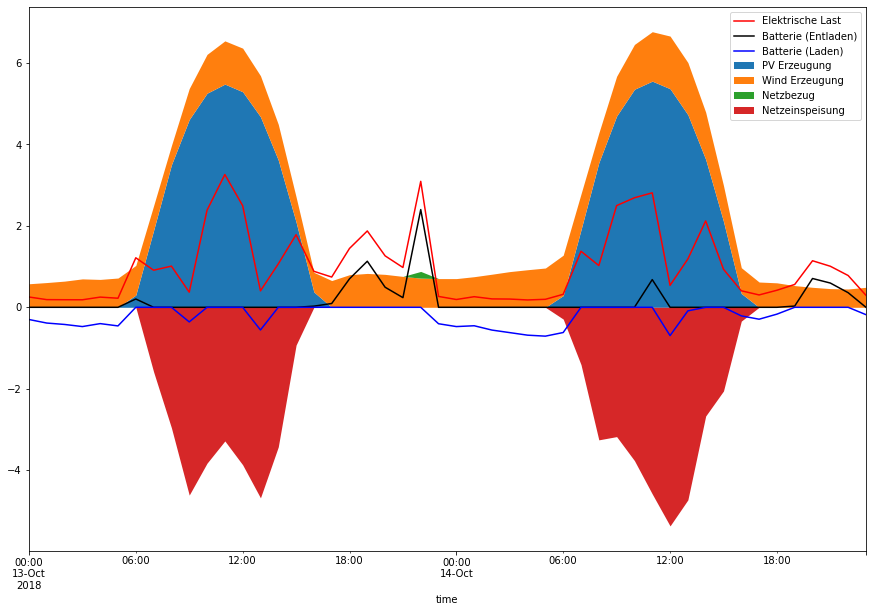

In [19]:
load_figure = pd.concat([network_modified_bat.loads_t.p_set['electricity_load'], network_modified_bat.links_t.p0['electricity_storage_discharge'],network_modified_bat.links_t.p1['electrical_storage_charge']], axis = 1)
load_figure.columns = ['Elektrische Last', 'Batterie (Entladen)','Batterie (Laden)']
ax = load_figure.loc['10-13-18 00:00:00':'10-14-18 23:50:00'].plot(color = ['red', 'black','blue'], legend = True, stacked = False)
df_figure_base = pd.concat([network_modified_bat.generators_t.p['pv'],network_modified_bat.generators_t.p['wind'], network_modified_bat.generators_t.p['grid_import'], -network_modified_bat.generators_t.p['grid_export_pv']], axis = 1)
df_figure_base.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc['10-13-18 00:00:00':'10-14-18 23:50:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)


Die weißen Flächen werden von der Batterie gedeckt

### Nutzung des thermischen Speichers

#### Skizze des Systems mit thermischem Speicher
<img src="data/Thermstore.png">

Erneuter aufbau des Netzwerkes unter anderem Namen

In [20]:
#Netzwerk definieren
network_modified_thermstore = pypsa.Network() # Die Variable für das Netzwerk wird eingefüht und als PyPSA Objekt, definiert
network_modified_thermstore.set_snapshots(pv_infeed.index) #Erstellen der Zeitabschnitten für die ges. Simulation aus den PV-Daten


#Knoten erstellen
network_modified_thermstore.add("Bus", #der Knoten für die Elektische Seite wird erstellt
            name = "electricity") #der Knoten für die Elektische Seite wird benannt

network_modified_thermstore.add("Bus", #der Knoten für die PV Seite wird erstellt
            name = "pv_node")

network_modified_thermstore.add("Bus", #der Knoten für die thermisch Seite wird erstellt
            name = "thermal")


#Lasten definieren
network_modified_thermstore.add("Load", #Die elektrische Last wird erstellt
            name ="electricity_load", #Name wird gesetzt
            bus = "electricity", #angeschlossen am Knoten für Elektrik
            p_set = electrical_load.sum_kwh) #auslesung der Leustung aus der Datei.Spalte Umrechnung in kW nicht notwendig, da Zeitintervall in der Quelle 1h

network_modified_thermstore.add("Load", # Thermische last
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)


#Erzeugungseinheiten definieren
network_modified_thermstore.add("Generator", #PV-Anlage
            name = "pv",
            bus = "pv_node", #Leistung wird von oben aus der Variable abgerufen (hätte man auch hier eintippen können, wird aber auch später öffter benötigt)
            p_nom = pv["electrical_power"], #Verfügbare Leistung je Zeitpunkt wird aus der Datei gelesen
            p_max_pu = pv_infeed.p_max_pu, #keine Erzeugungkosten
            marginal_cost = 0) #keine Erzeugungkosten

network_modified_thermstore.add("Generator", #Wind-Anlage
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

network_modified_thermstore.add("Generator", #Heizkessel
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], #werte werden von oben ausgelsen
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"]) #kosten werden mit den Angaben oben errechneet


#Netzanschluss definieren
network_modified_thermstore.add("Generator", #Netzbezug
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

network_modified_thermstore.add("Generator", #Netzeinspeisung pv
            name = "grid_export_pv",
            bus = "pv_node", 
            p_nom = grid_export_pv["electrical_power_pv"], 
            marginal_cost = -grid_export_pv["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.


#Verbindung der Knoten
network_modified_thermstore.add("Link", 
            name = "pv_node_to_electricity", 
            bus0 = "pv_node", 
            bus1 = "electricity", 
            p_nom = pv["electrical_power"])

#### Erweitung um Thermischen Speicher

 annuitätische Kosten von 100€ (7kWh Kapazität und eine Ein und Ausspeicherleistung von 12 kW, keine Selbstentladungsverluste)

In [21]:
# Hilfsknoten
network_modified_thermstore.add("Bus", 
            name = "storage_thermal")

#Einspeicherleistung vom Knoten "thermal" zum Knoten "storage_thermal"
network_modified_thermstore.add("Link", 
            name = "hot_water_storage_charge", 
            bus0 = "thermal", 
            bus1 = "storage_thermal", 
            p_nom = 12)

#Ausspeicherleistung vom Knoten "storage_thermal" zum Knoten "thermal"
network_modified_thermstore.add("Link", 
            name = "hot_water_storage_discharge", 
            bus0 = "storage_thermal", 
            bus1 = "thermal", 
            p_nom = 12)

#Speicher
network_modified_thermstore.add("Store", 
            name = "hot_water_storage", 
            bus = "storage_thermal", 
            e_nom = 7,
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            )

annu_cost_thermstore = 100

In [22]:
# Simulation für den kompletten Zeitraum:
network_modified_thermstore.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 2.2s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.14e+05


('ok', 'optimal')

In [23]:
results_with_modified_thermstore, results_energy_with_modified_thermstore  = cost_share_evaluation(network_modified_thermstore)

#Die Werte sollen auch als Text ausgegeben werden
print("Erzeugung_PV "+str(round(results_with_modified_thermstore["Erzeugung_PV"],2))+" vorher "+str(round(results_base["Erzeugung_PV"],2)))
print("Abregelung_PV "+str(round(results_with_modified_thermstore["Abregelung_PV"],2))+" vorher "+str(round(results_base["Abregelung_PV"],2)))
print("Erzeugung_wind "+str(round(results_with_modified_thermstore["Erzeugung_wind"],2))+" vorher "+str(round(results_base["Erzeugung_wind"],2)))
print("Netzbezug "+str(round(results_with_modified_thermstore["Netzbezug"],2))+" vorher "+str(round(results_base["Netzbezug"],2)))
print("Netzeinspeisung_PV "+str(round(results_with_modified_thermstore["Netzeinspeisung_PV"],2))+" vorher "+str(round(results_base["Netzeinspeisung_PV"],2)))
print("Eigenverbrauch_PV "+str(round(results_with_modified_thermstore["Eigenverbrauch_PV"],2))+" vorher "+str(round(results_base["Eigenverbrauch_PV"],2)))
print("Eigenverbrauch_wind "+str(round(results_with_modified_thermstore["Eigenverbrauch_wind"],2))+" vorher "+str(round(results_base["Eigenverbrauch_wind"],2)))
print("Eigenverbrauch_all "+str(round(results_with_modified_thermstore["Eigenverbrauch_all"],2))+" vorher "+str(round(results_base["Eigenverbrauch_all"],2)))
print("Verbrauch_total "+str(round(results_with_modified_thermstore["Verbrauch_total"],2))+" vorher "+str(round(results_base["Verbrauch_total"],2)))
print("Eigenverbrauchsanteil_pv "+str(round(results_with_modified_thermstore["Eigenverbrauchsanteil_pv"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_pv"]*100,2))+"%")
print("Eigenverbrauchsanteil_wind "+str(round(results_with_modified_thermstore["Eigenverbrauchsanteil_wind"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_wind"]*100,2))+"%")
print("Eigenverbrauchsanteil_all "+str(round(results_with_modified_thermstore["Eigenverbrauchsanteil_all"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_all"]*100,2))+"%")
print("Stromkosten "+str(round(results_with_modified_thermstore["Stromkosten"]/100,2))+" vorher "+str(round(results_base["Stromkosten"]/100,2)))
print("Gaskosten "+str(round(results_with_modified_thermstore["Gaskosten"]/100,2))+" vorher "+str(round(results_base["Gaskosten"]/100,2)))
print("Stromerlöse "+str(round(results_with_modified_thermstore["Stromerlöse"]/100,2))+" vorher "+str(round(results_base["Stromerlöse"]/100,2)))
print("Speicherkosten " +str(annu_cost_thermstore)+ " vorher 0 ")
print("Gesamtkosten "+str(round(results_with_modified_thermstore["Gesamtkosten"]/100+annu_cost_thermstore,2))+" vorher "+str(round(results_base["Gesamtkosten"]/100,2)))

Erzeugung_PV 11066.2 vorher 11066.2
Abregelung_PV 27.3 vorher 27.3
Erzeugung_wind 2398.88 vorher 2398.88
Netzbezug 1571.97 vorher 1571.97
Netzeinspeisung_PV 9969.51 vorher 9969.51
Eigenverbrauch_PV 1096.7 vorher 1096.7
Eigenverbrauch_wind 2398.88 vorher 2398.88
Eigenverbrauch_all 3495.57 vorher 3495.57
Verbrauch_total 5067.54 vorher 5067.54
Eigenverbrauchsanteil_pv 9.91% vorher 9.91%
Eigenverbrauchsanteil_wind 100.0% vorher 100.0%
Eigenverbrauchsanteil_all 25.96% vorher 25.96%
Stromkosten 471.59 vorher 471.59
Gaskosten 1891.83 vorher 1891.83
Stromerlöse 1226.25 vorher 1226.25
Speicherkosten 100 vorher 0 
Gesamtkosten 1237.17 vorher 1137.17


### Nutzung der Wärmepumpe

#### Skizze des Systems mit Wärmepumpe
<img src="data/WP.png">

Erneuter aufbau des Netzwerkes unter anderem Namen

In [24]:
#Netzwerk definieren
network_modified_wp = pypsa.Network() # Die Variable für das Netzwerk wird eingefüht und als PyPSA Objekt, definiert
network_modified_wp.set_snapshots(pv_infeed.index) #Erstellen der Zeitabschnitten für die ges. Simulation aus den PV-Daten


#Knoten erstellen
network_modified_wp.add("Bus", #der Knoten für die Elektische Seite wird erstellt
            name = "electricity") #der Knoten für die Elektische Seite wird benannt

network_modified_wp.add("Bus", #der Knoten für die PV Seite wird erstellt
            name = "pv_node")

network_modified_wp.add("Bus", #der Knoten für die thermisch Seite wird erstellt
            name = "thermal")


#Lasten definieren
network_modified_wp.add("Load", #Die elektrische Last wird erstellt
            name ="electricity_load", #Name wird gesetzt
            bus = "electricity", #angeschlossen am Knoten für Elektrik
            p_set = electrical_load.sum_kwh) #auslesung der Leustung aus der Datei.Spalte Umrechnung in kW nicht notwendig, da Zeitintervall in der Quelle 1h

network_modified_wp.add("Load", # Thermische last
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)


#Erzeugungseinheiten definieren
network_modified_wp.add("Generator", #PV-Anlage
            name = "pv",
            bus = "pv_node", #Leistung wird von oben aus der Variable abgerufen (hätte man auch hier eintippen können, wird aber auch später öffter benötigt)
            p_nom = pv["electrical_power"], #Verfügbare Leistung je Zeitpunkt wird aus der Datei gelesen
            p_max_pu = pv_infeed.p_max_pu, #keine Erzeugungkosten
            marginal_cost = 0) #keine Erzeugungkosten

network_modified_wp.add("Generator", #Wind-Anlage
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

network_modified_wp.add("Generator", #Heizkessel
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], #werte werden von oben ausgelsen
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"]) #kosten werden mit den Angaben oben errechneet


#Netzanschluss definieren
network_modified_wp.add("Generator", #Netzbezug
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

network_modified_wp.add("Generator", #Netzeinspeisung pv
            name = "grid_export_pv",
            bus = "pv_node", 
            p_nom = grid_export_pv["electrical_power_pv"], 
            marginal_cost = -grid_export_pv["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.


#Verbindung der Knoten
network_modified_wp.add("Link", 
            name = "pv_node_to_electricity", 
            bus0 = "pv_node", 
            bus1 = "electricity", 
            p_nom = pv["electrical_power"])

#### Erweitetrung um Wärmepumpe

Hier müssen Sie nach geeigneten Daten zu Leistungen, Kosten und Performance recherchieren. Sie dürfen dabei die Jahresarbeitszahl als konstanten COP annehmen. Gehen Sie weiter davon aus, dass der Annuitätenfaktor für eine solche Investition bei 0,117 liegt.

In [25]:
# BWL-1-08-I https://www.heizungsdiscount24.de/waermepumpen/wolf-bwl-1-08-i-hocheffizienz-luftwasser-waermepumpe-zur-innenaufstellung.html?gclid=CjwKCAjwtpGGBhBJEiwAyRZX2rh83B0Q9Prrii6Mv4-TpB4xYsps_QTuLOaB94rGjQlBqqiNNOLSPhoCmlMQAvD_BwE#os_det_pdflist
network_modified_wp.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="thermal", 
            p_nom=8.4,
            efficiency = 3.8
           )

C=6329 #[€]
ANF=0.117
a=C*ANF

annu_cost_wp = a

In [26]:
# Simulation für den kompletten Zeitraum:
network_modified_wp.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.28s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 5.06e+04


('ok', 'optimal')

In [27]:
results_with_modified_wp, results_energy_with_modified_wp  = cost_share_evaluation(network_modified_wp)

#Die Werte sollen auch als Text ausgegeben werden
print("Erzeugung_PV "+str(round(results_with_modified_wp["Erzeugung_PV"],2))+" vorher "+str(round(results_base["Erzeugung_PV"],2)))
print("Abregelung_PV "+str(round(results_with_modified_wp["Abregelung_PV"],2))+" vorher "+str(round(results_base["Abregelung_PV"],2)))
print("Erzeugung_wind "+str(round(results_with_modified_wp["Erzeugung_wind"],2))+" vorher "+str(round(results_base["Erzeugung_wind"],2)))
print("Netzbezug "+str(round(results_with_modified_wp["Netzbezug"],2))+" vorher "+str(round(results_base["Netzbezug"],2)))
print("Netzeinspeisung_PV "+str(round(results_with_modified_wp["Netzeinspeisung_PV"],2))+" vorher "+str(round(results_base["Netzeinspeisung_PV"],2)))
print("Eigenverbrauch_PV "+str(round(results_with_modified_wp["Eigenverbrauch_PV"],2))+" vorher "+str(round(results_base["Eigenverbrauch_PV"],2)))
print("Eigenverbrauch_wind "+str(round(results_with_modified_wp["Eigenverbrauch_wind"],2))+" vorher "+str(round(results_base["Eigenverbrauch_wind"],2)))
print("Eigenverbrauch_all "+str(round(results_with_modified_wp["Eigenverbrauch_all"],2))+" vorher "+str(round(results_base["Eigenverbrauch_all"],2)))
print("Verbrauch_total "+str(round(results_with_modified_wp["Verbrauch_total"],2))+" vorher "+str(round(results_base["Verbrauch_total"],2)))
print("Eigenverbrauchsanteil_pv "+str(round(results_with_modified_wp["Eigenverbrauchsanteil_pv"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_pv"]*100,2))+"%")
print("Eigenverbrauchsanteil_wind "+str(round(results_with_modified_wp["Eigenverbrauchsanteil_wind"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_wind"]*100,2))+"%")
print("Eigenverbrauchsanteil_all "+str(round(results_with_modified_wp["Eigenverbrauchsanteil_all"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_all"]*100,2))+"%")
print("Stromkosten "+str(round(results_with_modified_wp["Stromkosten"]/100,2))+" vorher "+str(round(results_base["Stromkosten"]/100,2)))
print("Gaskosten "+str(round(results_with_modified_wp["Gaskosten"]/100,2))+" vorher "+str(round(results_base["Gaskosten"]/100,2)))
print("Stromerlöse "+str(round(results_with_modified_wp["Stromerlöse"]/100,2))+" vorher "+str(round(results_base["Stromerlöse"]/100,2)))
print("Kosten der Wärmepumpe " +str(annu_cost_wp)+ " vorher 0 ")
print("Gesamtkosten "+str(round(results_with_modified_wp["Gesamtkosten"]/100+annu_cost_wp,2))+" vorher "+str(round(results_base["Gesamtkosten"]/100,2)))

Erzeugung_PV 11079.04 vorher 11066.2
Abregelung_PV 14.47 vorher 27.3
Erzeugung_wind 3864.28 vorher 2398.88
Netzbezug 1571.97 vorher 1571.97
Netzeinspeisung_PV 8366.14 vorher 9969.51
Eigenverbrauch_PV 2712.9 vorher 1096.7
Eigenverbrauch_wind 3864.28 vorher 2398.88
Eigenverbrauch_all 6577.18 vorher 3495.57
Verbrauch_total 8149.15 vorher 5067.54
Eigenverbrauchsanteil_pv 24.49% vorher 9.91%
Eigenverbrauchsanteil_wind 100.0% vorher 100.0%
Eigenverbrauchsanteil_all 44.01% vorher 25.96%
Stromkosten 471.59 vorher 471.59
Gaskosten 1063.84 vorher 1891.83
Stromerlöse 1029.04 vorher 1226.25
Kosten der Wärmepumpe 740.493 vorher 0 
Gesamtkosten 1246.89 vorher 1137.17


<AxesSubplot:xlabel='time'>

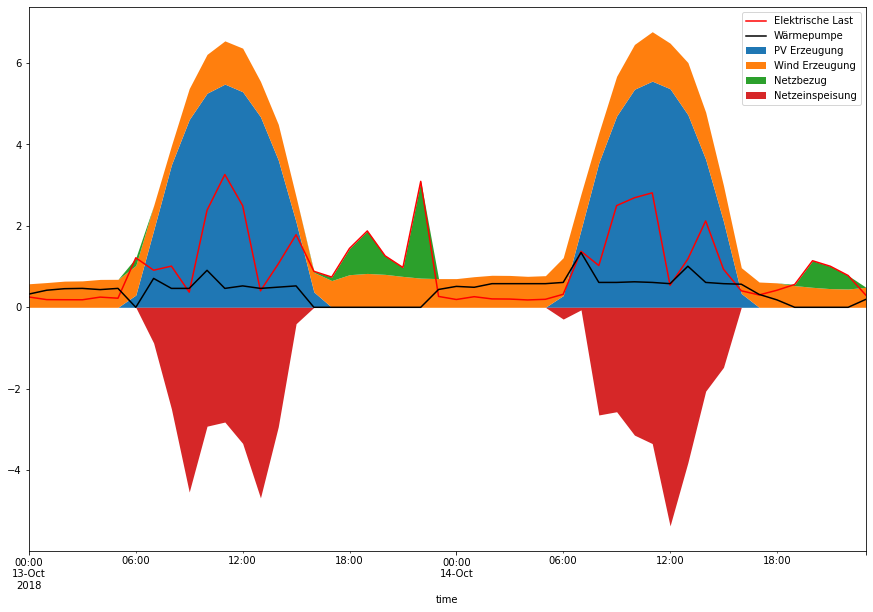

In [28]:
total_load_wp = pd.concat([network_modified_wp.loads_t.p_set['electricity_load'], network_modified_wp.links_t.p0['heat_pump']], axis = 1)
total_load_wp.columns = ['Elektrische Last', 'Wärmepumpe']
ax = total_load_wp.loc['10-13-18 00:00:00':'10-14-18 23:50:00'].plot(color = ['red', 'black'], legend = True, stacked = False)
df_figure_base = pd.concat([network_modified_wp.generators_t.p['pv'],network_modified_wp.generators_t.p['wind'], network_modified_wp.generators_t.p['grid_import'], -network_modified_wp.generators_t.p['grid_export_pv']], axis = 1)
df_figure_base.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc['10-13-18 00:00:00':'10-14-18 23:50:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)


## Zusammenfassung der Erweiterungen

|                                   | Basis Konfiguration | Erweiterung um die Batterie | Erweiterung um den therm. Speicher | Erweiterung um die Wärmepumpe |
|-----------------------------------|---------------------|-----------------------------|------------------------------------|-------------------------------|
| Netzbezug [kWh]                   | 1571.97             | 222.53                      | 1571.97                            | 1571.97                       |
| Eigenverbrauch (PV + Wind) [kWh]  | 3495.57             | 5094.86                     | 3495.57                            | 6577.18                       |
| Verbrauch [kWh]                   | 5067.54             | 5317.38                     | 5067.54                            | 8149.15                       |
| Eigenverbrauchsanteil (PV + Wind) | 25.96%              | 35.51%                      | 25.96%                             | 44.01%                        |
| Stromkosten [Euro]                | 471.59              | 66.76                       | 471.59                             | 471.59                        |
| Gaskosten [Euro]                  | 1891.83             | 1891.83                     | 1891.83                            | 1063.84                       |
| Stromerlöse [Euro]                | 1226.25             | 1138.21                     | 1226.25                            | 1029.04                       |
| Gesamtkosten [Euro]               | 1137.17             | 1720.38                     | 1237.17                            | 1246.89                       |

## Kombination der Wärmepumpe mit dem thermischen Speicher

#### Skizze des Systems mit Wärmepumpe und thermischem Speicher
<img src="data/WP_Thermstore.png">

Erneuter aufbau des Netzwerkes unter anderem Namen

In [29]:
#Netzwerk definieren
network_combination = pypsa.Network() # Die Variable für das Netzwerk wird eingefüht und als PyPSA Objekt, definiert
network_combination.set_snapshots(pv_infeed.index) #Erstellen der Zeitabschnitten für die ges. Simulation aus den PV-Daten


#Knoten erstellen
network_combination.add("Bus", #der Knoten für die Elektische Seite wird erstellt
            name = "electricity") #der Knoten für die Elektische Seite wird benannt

network_combination.add("Bus", #der Knoten für die PV Seite wird erstellt
            name = "pv_node")

network_combination.add("Bus", #der Knoten für die thermisch Seite wird erstellt
            name = "thermal")


#Lasten definieren
network_combination.add("Load", #Die elektrische Last wird erstellt
            name ="electricity_load", #Name wird gesetzt
            bus = "electricity", #angeschlossen am Knoten für Elektrik
            p_set = electrical_load.sum_kwh) #auslesung der Leustung aus der Datei.Spalte Umrechnung in kW nicht notwendig, da Zeitintervall in der Quelle 1h

network_combination.add("Load", # Thermische last
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)


#Erzeugungseinheiten definieren
network_combination.add("Generator", #PV-Anlage
            name = "pv",
            bus = "pv_node", #Leistung wird von oben aus der Variable abgerufen (hätte man auch hier eintippen können, wird aber auch später öffter benötigt)
            p_nom = pv["electrical_power"], #Verfügbare Leistung je Zeitpunkt wird aus der Datei gelesen
            p_max_pu = pv_infeed.p_max_pu, #keine Erzeugungkosten
            marginal_cost = 0) #keine Erzeugungkosten

network_combination.add("Generator", #Wind-Anlage
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

network_combination.add("Generator", #Heizkessel
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], #werte werden von oben ausgelsen
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"]) #kosten werden mit den Angaben oben errechneet


#Netzanschluss definieren
network_combination.add("Generator", #Netzbezug
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

network_combination.add("Generator", #Netzeinspeisung pv
            name = "grid_export_pv",
            bus = "pv_node", 
            p_nom = grid_export_pv["electrical_power_pv"], 
            marginal_cost = -grid_export_pv["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.


#Verbindung der Knoten
network_combination.add("Link", 
            name = "pv_node_to_electricity", 
            bus0 = "pv_node", 
            bus1 = "electricity", 
            p_nom = pv["electrical_power"])

#### Erweitetrung um Wärmepumpe

In [30]:
# BWL-1-08-I https://www.heizungsdiscount24.de/waermepumpen/wolf-bwl-1-08-i-hocheffizienz-luftwasser-waermepumpe-zur-innenaufstellung.html?gclid=CjwKCAjwtpGGBhBJEiwAyRZX2rh83B0Q9Prrii6Mv4-TpB4xYsps_QTuLOaB94rGjQlBqqiNNOLSPhoCmlMQAvD_BwE#os_det_pdflist
network_combination.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="thermal", 
            p_nom=8.4,
            efficiency = 3.8
           )

C=6329 #[€]
ANF=0.117
a=C*ANF

annu_cost_wp = a

#### Erweitung um Thermischen Speicher

In [31]:
# Hilfsknoten
network_combination.add("Bus", 
            name = "storage_thermal")

#Einspeicherleistung vom Knoten "thermal" zum Knoten "storage_thermal"
network_combination.add("Link", 
            name = "hot_water_storage_charge", 
            bus0 = "thermal", 
            bus1 = "storage_thermal", 
            p_nom = 12)

#Ausspeicherleistung vom Knoten "storage_thermal" zum Knoten "thermal"
network_combination.add("Link", 
            name = "hot_water_storage_discharge", 
            bus0 = "storage_thermal", 
            bus1 = "thermal", 
            p_nom = 12)

#Speicher
network_combination.add("Store", 
            name = "hot_water_storage", 
            bus = "storage_thermal", 
            e_nom = 7,
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            )

annu_cost_thermstore = 100

In [32]:
# Simulation für den kompletten Zeitraum:
network_combination.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.56s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 4.04e+04


('ok', 'optimal')

In [33]:
results_with_modified_combination, results_energy_with_modified_combination  = cost_share_evaluation(network_combination)

#Die Werte sollen auch als Text ausgegeben werden
print("Erzeugung_PV "+str(round(results_with_modified_combination["Erzeugung_PV"],2))+" vorher "+str(round(results_base["Erzeugung_PV"],2)))
print("Abregelung_PV "+str(round(results_with_modified_combination["Abregelung_PV"],2))+" vorher "+str(round(results_base["Abregelung_PV"],2)))
print("Erzeugung_wind "+str(round(results_with_modified_combination["Erzeugung_wind"],2))+" vorher "+str(round(results_base["Erzeugung_wind"],2)))
print("Netzbezug "+str(round(results_with_modified_combination["Netzbezug"],2))+" vorher "+str(round(results_base["Netzbezug"],2)))
print("Netzeinspeisung_PV "+str(round(results_with_modified_combination["Netzeinspeisung_PV"],2))+" vorher "+str(round(results_base["Netzeinspeisung_PV"],2)))
print("Eigenverbrauch_PV "+str(round(results_with_modified_combination["Eigenverbrauch_PV"],2))+" vorher "+str(round(results_base["Eigenverbrauch_PV"],2)))
print("Eigenverbrauch_wind "+str(round(results_with_modified_combination["Eigenverbrauch_wind"],2))+" vorher "+str(round(results_base["Eigenverbrauch_wind"],2)))
print("Eigenverbrauch_all "+str(round(results_with_modified_combination["Eigenverbrauch_all"],2))+" vorher "+str(round(results_base["Eigenverbrauch_all"],2)))
print("Verbrauch_total "+str(round(results_with_modified_combination["Verbrauch_total"],2))+" vorher "+str(round(results_base["Verbrauch_total"],2)))
print("Eigenverbrauchsanteil_pv "+str(round(results_with_modified_combination["Eigenverbrauchsanteil_pv"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_pv"]*100,2))+"%")
print("Eigenverbrauchsanteil_wind "+str(round(results_with_modified_combination["Eigenverbrauchsanteil_wind"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_wind"]*100,2))+"%")
print("Eigenverbrauchsanteil_all "+str(round(results_with_modified_combination["Eigenverbrauchsanteil_all"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_all"]*100,2))+"%")
print("Stromkosten "+str(round(results_with_modified_combination["Stromkosten"]/100,2))+" vorher "+str(round(results_base["Stromkosten"]/100,2)))
print("Gaskosten "+str(round(results_with_modified_combination["Gaskosten"]/100,2))+" vorher "+str(round(results_base["Gaskosten"]/100,2)))
print("Stromerlöse "+str(round(results_with_modified_combination["Stromerlöse"]/100,2))+" vorher "+str(round(results_base["Stromerlöse"]/100,2)))
print("Kosten der Erweiterung " +str(annu_cost_wp + annu_cost_thermstore)+ " vorher 0 ")
print("Gesamtkosten "+str(round(results_with_modified_combination["Gesamtkosten"]/100+(annu_cost_wp + annu_cost_thermstore),2))+" vorher "+str(round(results_base["Gesamtkosten"]/100,2)))

Erzeugung_PV 11085.92 vorher 11066.2
Abregelung_PV 7.59 vorher 27.3
Erzeugung_wind 4028.58 vorher 2398.88
Netzbezug 1571.97 vorher 1571.97
Netzeinspeisung_PV 7980.78 vorher 9969.51
Eigenverbrauch_PV 3105.14 vorher 1096.7
Eigenverbrauch_wind 4028.58 vorher 2398.88
Eigenverbrauch_all 7133.72 vorher 3495.57
Verbrauch_total 8705.69 vorher 5067.54
Eigenverbrauchsanteil_pv 28.01% vorher 9.91%
Eigenverbrauchsanteil_wind 100.0% vorher 100.0%
Eigenverbrauchsanteil_all 47.2% vorher 25.96%
Stromkosten 471.59 vorher 471.59
Gaskosten 914.31 vorher 1891.83
Stromerlöse 981.64 vorher 1226.25
Kosten der Erweiterung 840.493 vorher 0 
Gesamtkosten 1244.76 vorher 1137.17


<AxesSubplot:xlabel='time'>

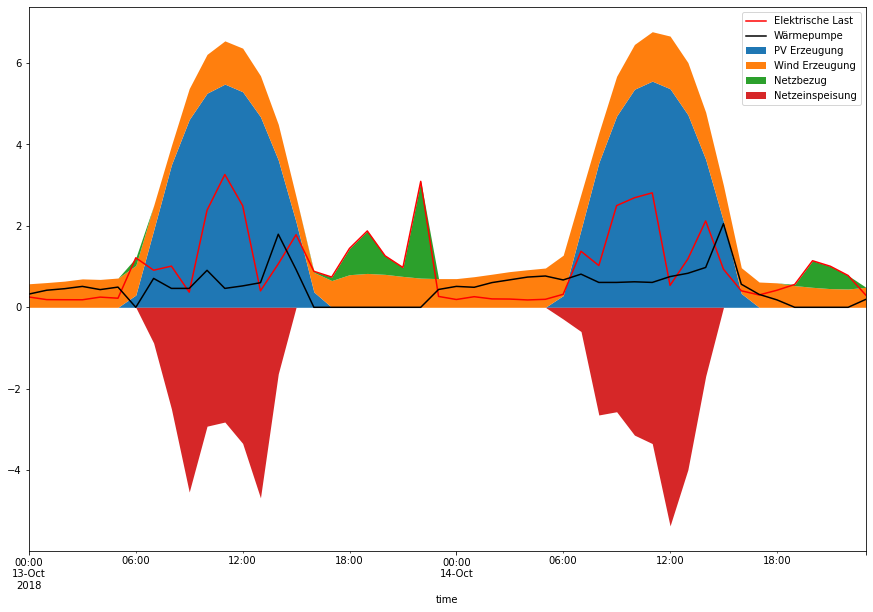

In [34]:
total_load_combination = pd.concat([network_combination.loads_t.p_set['electricity_load'], network_combination.links_t.p0['heat_pump']], axis = 1)
total_load_combination.columns = ['Elektrische Last', 'Wärmepumpe']
ax = total_load_combination.loc['10-13-18 00:00:00':'10-14-18 23:50:00'].plot(color = ['red', 'black'], legend = True, stacked = False)
df_figure_base = pd.concat([network_combination.generators_t.p['pv'],network_combination.generators_t.p['wind'], network_combination.generators_t.p['grid_import'], -network_combination.generators_t.p['grid_export_pv']], axis = 1)
df_figure_base.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc['10-13-18 00:00:00':'10-14-18 23:50:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)


## Kombination aller Erweiterungen

#### Skizze des Systems mit allen Erweiterungen
<img src="data/Full.png">

network_combination enthält bereits die Basiskonfiguration sowie die Wärmepumpe und den thermischen Speicher. Ein neues Modell muss nicht neu erstellt werden, es muss nur die Batterie hinzugefügt werden.

In [35]:
# Hilfsknoten
network_combination.add("Bus", 
            name = "storage_electricity")

#Einspeicherleistung vom Knoten "electricity" zum Knoten "storage_electricity"
network_combination.add("Link", 
            name = "electrical_storage_charge", 
            bus0 = "electricity", 
            bus1 = "storage_electricity", 
            p_nom = 2.4,
            efficiency = math.sqrt(0.85)) #Wurzel von 85% da sqrt_ein(0,85) * sqrt_aus(0,85) = 85% gesamt

#Ausspeicherleistung vom Knoten "storage_electricity" zum Knoten "electricity"
network_combination.add("Link", 
            name = "electricity_storage_discharge", 
            bus0 = "storage_electricity", 
            bus1 = "electricity", 
            p_nom = 2.4, 
            efficiency = math.sqrt(0.85)) #Wurzel von 85% da sqrt_ein(0,85) * sqrt_aus(0,85) = 85% gesamt

#Speicher
network_combination.add("Store", 
            name = "electricity_storage", 
            bus = "storage_electricity", 
            e_nom = 8, #Nominal energy capacity (in Dokumentation ist die Einheit in [MWh] angegeben. Waum hier [kWh]?)
            e_cyclic = True,)# Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen

annu_cost_bat = 900



In [36]:
# Simulation für den kompletten Zeitraum:
network_combination.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 2.4s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.17e+04


('ok', 'optimal')

In [37]:
results_with_modified_combination, results_energy_with_modified_combination  = cost_share_evaluation(network_combination)

#Die Werte sollen auch als Text ausgegeben werden
print("Erzeugung_PV "+str(round(results_with_modified_combination["Erzeugung_PV"],2))+" vorher "+str(round(results_base["Erzeugung_PV"],2)))
print("Abregelung_PV "+str(round(results_with_modified_combination["Abregelung_PV"],2))+" vorher "+str(round(results_base["Abregelung_PV"],2)))
print("Erzeugung_wind "+str(round(results_with_modified_combination["Erzeugung_wind"],2))+" vorher "+str(round(results_base["Erzeugung_wind"],2)))
print("Netzbezug "+str(round(results_with_modified_combination["Netzbezug"],2))+" vorher "+str(round(results_base["Netzbezug"],2)))
print("Netzeinspeisung_PV "+str(round(results_with_modified_combination["Netzeinspeisung_PV"],2))+" vorher "+str(round(results_base["Netzeinspeisung_PV"],2)))
print("Eigenverbrauch_PV "+str(round(results_with_modified_combination["Eigenverbrauch_PV"],2))+" vorher "+str(round(results_base["Eigenverbrauch_PV"],2)))
print("Eigenverbrauch_wind "+str(round(results_with_modified_combination["Eigenverbrauch_wind"],2))+" vorher "+str(round(results_base["Eigenverbrauch_wind"],2)))
print("Eigenverbrauch_all "+str(round(results_with_modified_combination["Eigenverbrauch_all"],2))+" vorher "+str(round(results_base["Eigenverbrauch_all"],2)))
print("Verbrauch_total "+str(round(results_with_modified_combination["Verbrauch_total"],2))+" vorher "+str(round(results_base["Verbrauch_total"],2)))
print("Eigenverbrauchsanteil_pv "+str(round(results_with_modified_combination["Eigenverbrauchsanteil_pv"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_pv"]*100,2))+"%")
print("Eigenverbrauchsanteil_wind "+str(round(results_with_modified_combination["Eigenverbrauchsanteil_wind"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_wind"]*100,2))+"%")
print("Eigenverbrauchsanteil_all "+str(round(results_with_modified_combination["Eigenverbrauchsanteil_all"]*100,2))+"% vorher "+str(round(results_base["Eigenverbrauchsanteil_all"]*100,2))+"%")
print("Stromkosten "+str(round(results_with_modified_combination["Stromkosten"]/100,2))+" vorher "+str(round(results_base["Stromkosten"]/100,2)))
print("Gaskosten "+str(round(results_with_modified_combination["Gaskosten"]/100,2))+" vorher "+str(round(results_base["Gaskosten"]/100,2)))
print("Stromerlöse "+str(round(results_with_modified_combination["Stromerlöse"]/100,2))+" vorher "+str(round(results_base["Stromerlöse"]/100,2)))
print("Kosten der Erweiterung " +str(annu_cost_wp + annu_cost_thermstore + annu_cost_bat)+ " vorher 0 ")
print("Gesamtkosten "+str(round(results_with_modified_combination["Gesamtkosten"]/100+(annu_cost_wp + annu_cost_thermstore + annu_cost_bat),2))+" vorher "+str(round(results_base["Gesamtkosten"]/100,2)))

Erzeugung_PV 11090.06 vorher 11066.2
Abregelung_PV 3.44 vorher 27.3
Erzeugung_wind 4278.36 vorher 2398.88
Netzbezug 385.55 vorher 1571.97
Netzeinspeisung_PV 6153.18 vorher 9969.51
Eigenverbrauch_PV 4936.89 vorher 1096.7
Eigenverbrauch_wind 4278.36 vorher 2398.88
Eigenverbrauch_all 9215.25 vorher 3495.57
Verbrauch_total 9600.79 vorher 5067.54
Eigenverbrauchsanteil_pv 44.52% vorher 9.91%
Eigenverbrauchsanteil_wind 100.0% vorher 100.0%
Eigenverbrauchsanteil_all 59.96% vorher 25.96%
Stromkosten 115.66 vorher 471.59
Gaskosten 758.19 vorher 1891.83
Stromerlöse 756.84 vorher 1226.25
Kosten der Erweiterung 1740.493 vorher 0 
Gesamtkosten 1857.51 vorher 1137.17


total_load_combination = pd.concat([network_combination.loads_t.p_set['electricity_load'], network_combination.links_t.p0['heat_pump']], axis = 1) 
total_load_combination.columns = ['Elektrische Last', 'Wärmepumpe'] 
ax = total_load_combination.loc['10-13-18 00:00:00':'10-14-18 23:50:00'].plot(color = ['red', 'black'], legend = True, stacked = False)

df_figure_batterie = pd.concat([network_combination.links_t.p['electricity_storage_discharge'],network_combination.links_t.p['electrical_storage_charge']], axis = 1)
df_figure_batterie.columns = ['Batterie (Entladen)','Batterie (Laden)']
df_figure_batterie.loc['10-13-18 00:00:00':'10-14-18 23:50:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'line', linewidth=1, ax=ax)

df_figure_base = pd.concat([network_combination.generators_t.p['pv'],network_combination.generators_t.p['wind'], network_combination.generators_t.p['grid_import'], -network_combination.generators_t.p['grid_export_pv']], axis = 1)
df_figure_base.columns = ['PV Erzeugung', 'Wind Erzeugung', 'Netzbezug', 'Netzeinspeisung']
df_figure_base.loc['10-13-18 00:00:00':'10-14-18 23:50:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)

## Zusammenfassung der Kombinationen

|                                   | Basis Konfiguration | Kombination 1 | Kombination 2 |
|-----------------------------------|---------------------|---------------|---------------|
| Netzbezug [kWh]                   | 1571.97             | 1571.97       | 385.55        |
| Eigenverbrauch (PV + Wind) [kWh]  | 3495.57             | 7133.72       | 9215.25       |
| Verbrauch [kWh]                   | 5067.54             | 8705.69       | 9600.79       |
| Eigenverbrauchsanteil (PV + Wind) | 25.96%              | 47.2%         | 59.96%        |
| Stromkosten [Euro]                | 471.59              | 471.59        | 115.66        |
| Gaskosten [Euro]                  | 1891.83             | 914.31        | 758.19        |
| Stromerlöse [Euro]                | 1226.25             | 981.64        | 756.84        |
| Gesamtkosten [Euro]               | 1137.17             | 1244.76       | 1857.51       |